In [14]:
import matplotlib 
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn import svm

import glob
import json
import pickle
import operator
import numpy as np
import seaborn as sns
from scipy import stats
sns.set(style="ticks")
import statsmodels.api as sm
import pandas as pd
from scipy.stats import chisquare
from matplotlib import rcParams
from matplotlib.backends.backend_pdf import PdfPages
from pandas.tools.plotting import parallel_coordinates
import mpl_toolkits.axes_grid1 as axes_grid1
rcParams['mathtext.default'] = 'regular'
%matplotlib inline

print('Done')

Done


In [20]:
#Load-in H-chain data

at=['H']

dat_l=[]

suffix='iao'

spins=[0]

evc=27.2114
dat=pd.read_csv('H_chain_data.csv')

print('Done')

Done


Done


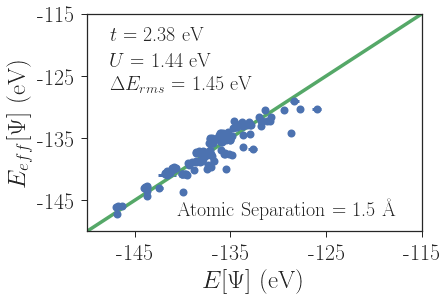

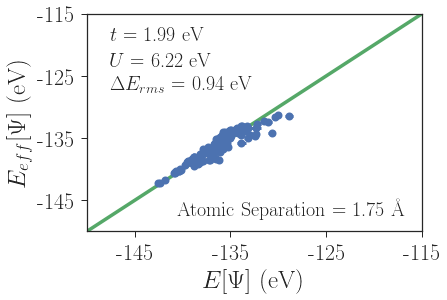

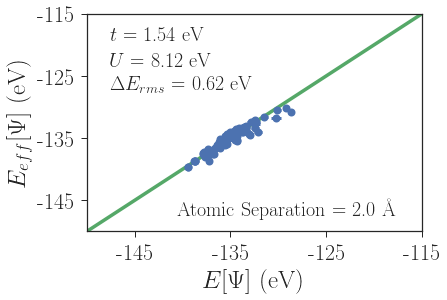

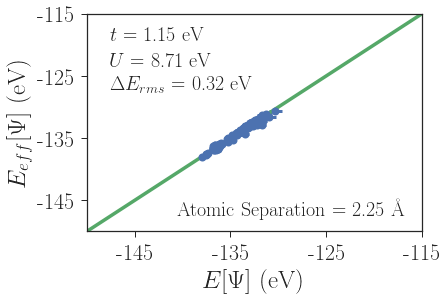

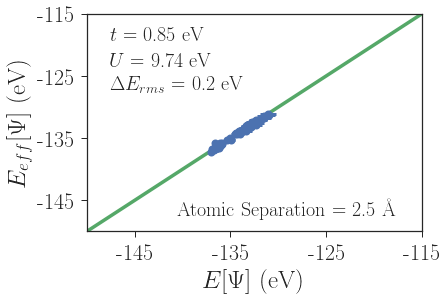

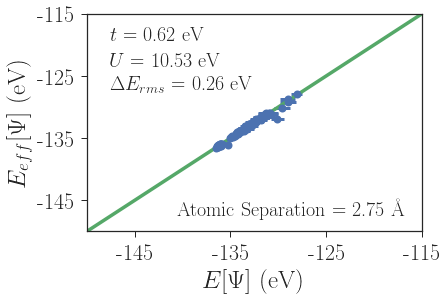

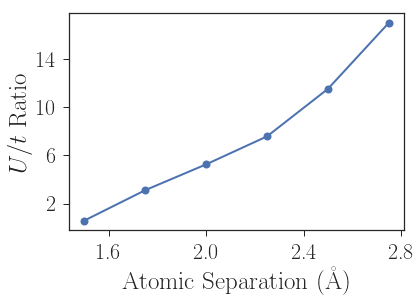

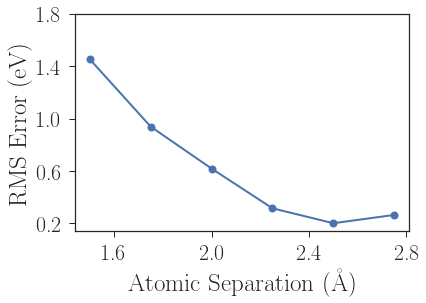

In [22]:
#Plot QMC vs. Model energies, and U/t ratio versus bond length,
#and RMS deviation versus bond length

from scipy.optimize import least_squares
evc=27.2114
func_choice='pbe'
lengths=[1.50, 1.75, 2.0, 2.25, 2.5, 2.75]
dat_func=dat[ dat['functional']==func_choice ]
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

def fun(parms, dum_descrip, E):
    nparm=len(parms)
    est=np.zeros(len(dum_descrip))
    for l in range(len(dum_descrip)):
      for k in range(nparm):
        est[l]+=parms[k]*dum_descrip[l][k]
    return est-E

def mod_energy(fit_parms, dum_descrip):
    nparm=len(fit_parms)
    est=np.zeros(len(dum_descrip))
    for l in range(len(dum_descrip)):
      for k in range(nparm):
        est[l]+=fit_parms[k]*dum_descrip[l][k]
    return est

energy_ticks=[-145, -135, -125, -115]
length_ticks=[1.6, 2.0, 2.4, 2.8]
rms_ticks=[0.2, 0.6, 1.0, 1.4, 1.8]
ut_rat_ticks=[2,6,10,14]

filemod=''
parameters=['Constant', 't', 'Us']
par_names=['C', 't', 'U']

param_hold=[[] for k in range(len(parameters)-1)]

rms_hold=[]
r2_hold=[]

#####################################################
#Change font sizes here!

fs=25    #Fontsize of axis labels
tfs=22   #Fontsize of tick labels
afs=20   #Fontsize of annotated text

#####################################################

x0=[np.min(dat_func['energy'])]
for k in range(len(parameters)-1):
    parm_name=parameters[k+1]
    filemod+=np.str(parm_name)
    x0+=[0]

for ln in range(len(lengths)):
    plt.figure(ln)
    length=lengths[ln]
    dat_func=dat[ dat['Length']==length ]
    descrip=np.zeros((len(dat_func['Constant']), len(parameters)))
    for i,p in enumerate(parameters):
        descrip[:,i]=np.array(dat_func[p])

    ab_energy=evc*dat_func['energy']
    ab_err=evc*dat_func['error']

    res_lin = least_squares(fun, x0, loss='linear', args=(descrip, ab_energy))
    model_energy = mod_energy(res_lin.x, descrip)
        
    resid=ab_energy-model_energy
    resid=np.array(resid)
    rms=np.sqrt(np.sum(resid**2)/len(resid))

    lw=0
    ms=8

    plt.errorbar(ab_energy, model_energy, xerr=ab_err, elinewidth=3, linewidth=lw, marker='o', markersize=ms-2, mew=2)
    plt.plot([100*np.min(model_energy), 0], [100*np.min(model_energy), 0], linewidth=lw+3.5)
    plt.xticks(energy_ticks, energy_ticks, fontsize=tfs)
    plt.yticks(energy_ticks, energy_ticks, fontsize=tfs)
    plt.ylabel('$E_{eff} [\Psi]$ (eV)', fontsize=fs)
    plt.xlabel('$E [\Psi]$ (eV)', fontsize=fs)
    plt.xlim([-150, -115])
    plt.ylim([-150, -115])
    
#    plt.title('Atomic Separation (\AA): '+np.str(length), fontsize=fs-5)

    capy=0.88
    for k in range(1,len(parameters)):
        plt.annotate("$"+par_names[k]+"$ = "+np.str(np.round(np.abs(res_lin.x[k]), 2))+" eV", xy=(0.07,capy), xycoords='axes fraction', fontsize=afs)
        capy-=0.12
        
    plt.annotate(" $\Delta E_{rms}$ = "+np.str(np.round(rms, 2))+" eV", xy=(0.07,capy), xycoords='axes fraction', fontsize=afs)
    rms_hold.append(rms)
    
    capy-=0.1
    plt.annotate("Atomic Separation = "+np.str(np.round(length, 2))+" \AA", xy=(0.27,0.07), xycoords='axes fraction', fontsize=afs)
    
        
    for n in range(len(parameters)-1):
      param_hold[n].append(res_lin.x[n+1])

#    plt.savefig('H_chain_fit_model_length'+np.str(length)+'_'+np.str(filemod)+'.ps', bbox_inches='tight')
    plt.savefig('H_chain_fit_model_length'+np.str(length)+'_'+np.str(filemod)+'.pdf', bbox_inches='tight')
#    plt.savefig('H_chain_fit_model_length'+np.str(length)+'_'+np.str(filemod)+'.eps', bbox_inches='tight')
    plt.savefig('H_chain_fit_model_length'+np.str(length)+'_'+np.str(filemod)+'.png', dpi=200, bbox_inches='tight')



c=len(lengths)+1

if len(parameters)==3:
  plt.figure(c)
  c+=1
  plt.plot(lengths, np.abs(np.array(param_hold[1])/np.array(param_hold[0])), linewidth=lw+2, marker='o', markersize=ms-2, mew=2)
  plt.xticks(length_ticks, length_ticks, fontsize=tfs)
  plt.yticks(ut_rat_ticks, ut_rat_ticks, fontsize=tfs)
  plt.xlabel('Atomic Separation (\AA)', fontsize=fs)
  plt.ylabel('$U/t$ Ratio', fontsize=fs)
  plt.savefig(np.str(parameters[2])+np.str(parameters[1])+'_ratio_vs_separation_h_chain.png', dpi=200, bbox_inches='tight')
  plt.savefig(np.str(parameters[2])+np.str(parameters[1])+'_ratio_vs_separation_h_chain.pdf', bbox_inches='tight')


plt.figure(c)
c+=1
plt.plot(lengths, rms_hold, linewidth=lw+2, marker='o', markersize=ms-2, mew=2)
plt.xticks(length_ticks, length_ticks, fontsize=tfs)
plt.yticks(rms_ticks, rms_ticks, fontsize=tfs)
plt.xlabel('Atomic Separation (\AA)', fontsize=fs)
plt.ylabel('RMS Error (eV)', fontsize=fs)
plt.xticks(fontsize=tfs)
plt.yticks(fontsize=tfs)
#plt.title('RMS Error in $U-t$ Model Relative to QMC', fontsize=fs)
plt.savefig('rms_ut_error_vs_separation_h_chain.png', bbox_inches='tight', dpi=200)
plt.savefig('rms_ut_error_vs_separation_h_chain.pdf', bbox_inches='tight')
plt.savefig('rms_ut_error_vs_separation_h_chain.eps', bbox_inches='tight')
    
print('Done')

Done


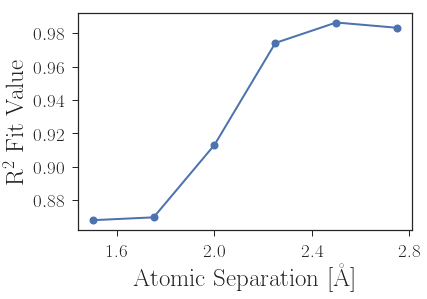

In [10]:
#Plot R^2 value of fit versus bond length

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
evc=27.2114
c=1

def fit_dataframe(parameters,df):
  nparms=len(parameters)
  npts=len(df)
  A=np.zeros((npts,nparms))
  for i,p in enumerate(parameters):
    A[:,i]=np.array(df[p])
  K=np.array(df['energy'])
  x,res,rank,s=np.linalg.lstsq(A,K)
  K_mod=np.dot(A,x)
  Kerr=np.array(df['error'])
  return x,res,K,Kerr,K_mod  

def fit_dataframe_ols(parameters,df):
  evc=27.2114
  nparms=len(parameters)
  npts=len(df)
  A=np.zeros((npts,nparms))
  for i,p in enumerate(parameters):
    A[:,i]=np.array(df[p])
  K=np.array(df['energy'])*evc

  model=sm.OLS(K,A).fit()
  results = model  
  return model,A,K  


length_ticks=[1.6, 2.0, 2.4, 2.8]

DM_terms=['Constant', 't', 'Us']
r2_hold=[]

params={}
for p in DM_terms:
    params[p]={'Value':[], 'Error':[]}

lengths=[1.5, 1.75, 2.0, 2.25, 2.5, 2.75]
dat_func=dat[ dat['functional']==func_choice ]

for il,l in enumerate(lengths):
    dat_L=dat_func[ dat_func['Length']==l ]
    x=fit_dataframe(DM_terms,dat_L)
    mod,X,Y=fit_dataframe_ols(DM_terms,dat_L)
    r2=mod.rsquared
    r2_hold.append(r2)
    E_ab=x[2]
    E_err=x[3]
    E_mod=x[4]
    E_err_mod=(np.array(E_ab)-np.array(E_mod))
    for iv,v in enumerate(x[0]):
        params[DM_terms[iv]]['Value'].append(v)
        params[DM_terms[iv]]['Error'].append(mod.bse[iv])
    

plt.figure(c)
c+=1
plt.plot(lengths, r2_hold, linewidth=lw+2, marker='o', markersize=ms-2, mew=2)
plt.xlabel('Atomic Separation [\AA]', fontsize=fs)
plt.ylabel('{R}$^2$ Fit Value', fontsize=fs)
plt.xticks(length_ticks, length_ticks, fontsize=tfs-3)
#plt.title('Title', fontsize=fs)
plt.yticks(fontsize=tfs-3)
plt.savefig('r2_ut_vs_separation_h_chain.pdf', bbox_inches='tight')
plt.savefig('r2_ut_vs_separation_h_chain.eps', bbox_inches='tight')
plt.savefig('r2_ut_vs_separation_h_chain.png', bbox_inches='tight', dpi=200)

print('Done')

Done


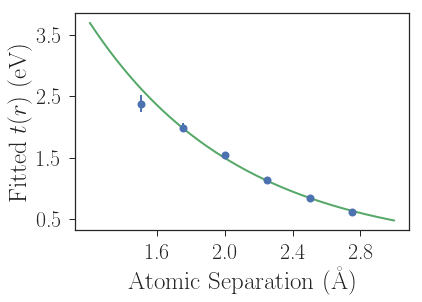

In [11]:
#Fit exponential curve to t(r) parameter for U-t model
from scipy.optimize import curve_fit

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
evc=27.2114
func_choice='pbe'

lw=0
ms=8

def fit_dataframe(parameters,df):
  nparms=len(parameters)
  npts=len(df)
  A=np.zeros((npts,nparms))
  for i,p in enumerate(parameters):
    A[:,i]=np.array(df[p])
  K=np.array(df['energy'])
  x,res,rank,s=np.linalg.lstsq(A,K)
  K_mod=np.dot(A,x)
  Kerr=np.array(df['error'])
  return x,res,K,Kerr,K_mod  

def fit_dataframe_ols(parameters,df):
  evc=27.2114
  nparms=len(parameters)
  npts=len(df)
  A=np.zeros((npts,nparms))
  for i,p in enumerate(parameters):
    A[:,i]=np.array(df[p])
  K=np.array(df['energy'])*evc

  model=sm.OLS(K,A).fit()
  results = model
  
  return model,A,K  

DM_terms=['Constant', 't', 'Us']

length_ticks=[1.6, 2.0, 2.4, 2.8]

params={}
for p in DM_terms:
    params[p]={'Value':[], 'Error':[]}

lengths=[1.5, 1.75, 2.0, 2.25, 2.5, 2.75]
dat_func=dat[ dat['functional']==func_choice ]

for il,l in enumerate(lengths):
    dat_L=dat_func[ dat_func['Length']==l ]
    x=fit_dataframe(DM_terms,dat_L)
    mod,X,Y=fit_dataframe_ols(DM_terms,dat_L)
    E_ab=x[2]
    E_err=x[3]
    E_mod=x[4]
    E_err_mod=(np.array(E_ab)-np.array(E_mod))
    for iv,v in enumerate(x[0]):
        params[DM_terms[iv]]['Value'].append(v)
        params[DM_terms[iv]]['Error'].append(mod.bse[iv])

t_values=params['t']['Value']
t_err=params['t']['Error']

t_ticks=[3.5,2.5,1.5,0.5]

curve_param, curve_cov =curve_fit(lambda t,a,b: a*np.exp(-1*t/b),  lengths,  evc*np.array(t_values), p0=(1,1), sigma=t_err)

curve_std=np.sqrt(np.diag(curve_cov))

a_fit=curve_param[0]
b_fit=curve_param[1]

x_fit=np.linspace(1.2,3,500)
y_fit=(a_fit*np.exp(-1*x_fit/b_fit))


plt.errorbar(lengths, -1*evc*np.array(t_values), yerr=t_err, elinewidth=2, linewidth=0, marker='o', markersize=ms-2, mew=2)
plt.plot(x_fit, -1*y_fit, linewidth=2, markersize=0, mew=2)
plt.xlabel('Atomic Separation (\AA)', fontsize=fs)
plt.ylabel('Fitted  $t(r)$ (eV)', fontsize=fs)
plt.xticks(length_ticks, length_ticks, fontsize=tfs)
plt.yticks(t_ticks, t_ticks, fontsize=tfs)
#plt.title('Fitted $t$ Values vs. Separation, H$_{10}$ Chain, PBE', fontsize=fs)

capy=0.85
round_num=2
#plt.annotate("$t (r) = t_0 \: e^{-r / r_0 }$", xy=(0.1,capy), xycoords='axes fraction', fontsize=18)
#plt.annotate("$ t_0 =$ "+np.str(np.round(curve_param[0], round_num))+" ("+np.str(np.round(curve_std[0], round_num))+") eV", xy=(0.5,0.30), xycoords='axes fraction', fontsize=15)
#plt.annotate("$ r_0 =$ "+np.str(np.round(curve_param[1], round_num))+" ("+np.str(np.round(curve_std[1], round_num))+") \AA", xy=(0.5,0.20), xycoords='axes fraction', fontsize=15)

plt.savefig('fitted_t_values_no_offset_h10_chain.pdf', bbox_inches='tight')
plt.savefig('fitted_t_values_no_offset_h10_chain.png', bbox_inches='tight', dpi=200)

print('Done')

Done


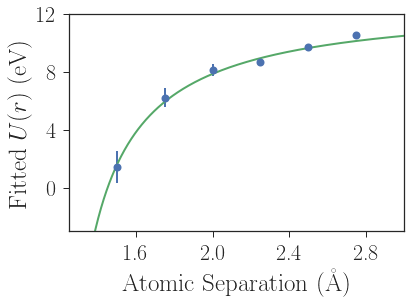

In [12]:
# Fit U(r) to 1/r model, with fixed U0=13.6, minus electron affinity of hydrogen,
# letting singularity position shift

#Fit curve to t parameter for U-t model, with no offset
from scipy.optimize import curve_fit

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
evc=27.2114
func_choice='pbe'

lw=0
ms=8

def fit_dataframe(parameters,df):
  nparms=len(parameters)
  npts=len(df)
  A=np.zeros((npts,nparms))
  for i,p in enumerate(parameters):
    A[:,i]=np.array(df[p])
  K=np.array(df['energy'])
  x,res,rank,s=np.linalg.lstsq(A,K)
  K_mod=np.dot(A,x)
  Kerr=np.array(df['error'])
  return x,res,K,Kerr,K_mod  

def fit_dataframe_ols(parameters,df):
  evc=27.2114
  nparms=len(parameters)
  npts=len(df)
  A=np.zeros((npts,nparms))
  for i,p in enumerate(parameters):
    A[:,i]=np.array(df[p])
  K=np.array(df['energy'])*evc

  model=sm.OLS(K,A).fit()
  results = model  
  return model,A,K  


DM_terms=['Constant', 't', 'Us']

U_ticks=[0, 4, 8, 12]

params={}
for p in DM_terms:
    params[p]={'Value':[], 'Error':[]}

lengths=[1.5, 1.75, 2.0, 2.25, 2.5, 2.75]
dat_func=dat[ dat['functional']==func_choice ]

for il,l in enumerate(lengths):
    dat_L=dat_func[ dat_func['Length']==l ]
    x=fit_dataframe(DM_terms,dat_L)
    mod,X,Y=fit_dataframe_ols(DM_terms,dat_L)
    E_ab=x[2]
    E_err=x[3]
    E_mod=x[4]
    E_err_mod=(np.array(E_ab)-np.array(E_mod))
    for iv,v in enumerate(x[0]):
        params[DM_terms[iv]]['Value'].append(v)
        params[DM_terms[iv]]['Error'].append(mod.bse[iv])

U_values=params['Us']['Value']
U_err=params['Us']['Error']

H_affinity=0.754
U0=13.6-H_affinity

start=0
curve_param, curve_cov =curve_fit(lambda r,a,b: U0*(1-a/(r-b)),  lengths[start:5],  evc*np.array(U_values)[start:5], p0=(1,0), sigma=U_err[start:5])

curve_std=np.sqrt(np.diag(curve_cov))

a_fit=curve_param[0]
b_fit=curve_param[1]

x_fit=np.linspace(1.2,3,500)
y_fit=(U0*(1-a_fit/np.array(x_fit-b_fit)))

plt.errorbar(lengths, evc*np.array(U_values), yerr=U_err, elinewidth=2, linewidth=0, marker='o', markersize=ms-2, mew=2)
plt.plot(x_fit, y_fit, linewidth=2, markersize=0, mew=2)
plt.xlabel('Atomic Separation (\AA)', fontsize=fs)
plt.ylabel('Fitted  $U(r)$ (eV)', fontsize=fs)
#plt.title('Fitted $U$ Values vs. Separation, H$_{10}$ Chain, PBE', fontsize=fs)

capy=0.85
round_num=2
#plt.annotate("$U (r) = U_0 \: [1-r_0 /(r-r_c)]$", xy=(0.35,0.5), xycoords='axes fraction', fontsize=18)
#plt.annotate("$ r_0 =$ "+np.str(np.round(curve_param[0], round_num))+" ("+np.str(np.round(curve_std[0], round_num))+") \AA", xy=(0.5,0.30), xycoords='axes fraction', fontsize=15)
#plt.annotate("$ r_c =$ "+np.str(np.round(curve_param[1], round_num))+" ("+np.str(np.round(curve_std[1], round_num))+") \AA", xy=(0.5,0.20), xycoords='axes fraction', fontsize=15)
#plt.annotate("$ U_0 =$ "+np.str(np.round(U0, round_num))+" eV", xy=(0.5,0.10), xycoords='axes fraction', fontsize=15)
plt.ylim([-3,12])
plt.xlim([1.25, 3.0])
plt.xticks(length_ticks, length_ticks, fontsize=tfs)
plt.yticks(U_ticks, U_ticks, fontsize=tfs)

plt.savefig('fitted_U_values_no_offset_h10_chain.pdf', bbox_inches='tight')
plt.savefig('fitted_U_values_no_offset_h10_chain.png', bbox_inches='tight', dpi=200)

print('Done')